In [1]:
# %pip install pandas numpy
# %pip install scikit-learn
# %pip install RDKit
# %pip install matplotlib networkx
# %pip install tqdm 
# %pip install rdkit
# %pip install xgboost
# %pip install sklearn
# %pip install lightgbm


In [2]:
## 网格搜索调参
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (recall_score, accuracy_score, confusion_matrix)
from sklearn.base import clone
from lightgbm import LGBMClassifier



In [3]:
tox_data = pd.read_csv('../data/tox21.csv')
tox_data.head(2)

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O


In [4]:
nbt = 2048
threshold = 0.3

# 思路记录
## 

# 1.数据预处理
### 缺失值
- `用1填充`：宁愿误判为有毒性也不判为无毒 ❌效果不理想

- `略过缺失值`?
逐标签过滤缺失值 ✅	模型严谨、标签缺失较多时



In [5]:
# Step 1: 识别标签列（12个毒性相关的列）
label_cols = [
    'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER',
    'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5',
    'SR-HSE', 'SR-MMP', 'SR-p53'
]

# Step 2: 统计标签完全缺失和完全非缺失的样本数量
total_samples = tox_data.shape[0]
all_nan_labels = tox_data[label_cols].isna().all(axis=1).sum()
no_nan_labels = tox_data[label_cols].notna().all(axis=1).sum()
partial_nan_labels = total_samples - all_nan_labels - no_nan_labels

{
    "总样本数": total_samples,
    "标签全缺失样本数": int(all_nan_labels),
    "标签无缺失样本数": int(no_nan_labels),
    "标签部分缺失样本数": int(partial_nan_labels)
}
# 统计每个标签缺失值的数量
missing_counts_per_label = tox_data[label_cols].isna().sum().sort_values(ascending=False)

missing_counts_per_label

# ## 缺失样本设置为1（不具备该特征）
# # 将所有标签列中的缺失值填充为 0，表示“无该毒性特征”
# tox_data[label_cols] = tox_data[label_cols].fillna(1)

# # 检查是否填充成功（应返回 0）
# remaining_missing = tox_data[label_cols].isna().sum().sum()
# int(remaining_missing)


SR-MMP           2092
SR-ARE           2078
NR-Aromatase     2072
NR-ER            1697
NR-PPAR-gamma    1430
SR-HSE           1419
NR-AhR           1322
NR-AR-LBD        1111
SR-p53           1104
NR-ER-LBD         901
SR-ATAD5          781
NR-AR             574
dtype: int64

## 📍 Step 2：特征工程（分子指纹提取）
### 使用 RDKit 提取每个 SMILES 的 ECFP4指纹：

- radius=2，生成 ECFP4
- 设置固定向量长度，如 nBits=1024
- 每个分子将转换为一个 0/1的稀疏向量

### 最终特征矩阵形状：(num_samples, 1024)

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm

# 定义 SMILES → ECFP4 指纹向量函数
def smiles_to_ecfp4(smiles, radius=2, nBits= nbt):
    mol = Chem.MolFromSmiles(smiles)  # 用RDKit将SMILES转成分子对象（Mol）
    if mol is None:
        return np.zeros(nBits, dtype=int)  # 无效的SMILES返回全0向量

    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)  
    # 生成ECFP4分子指纹，radius=2表示ECFP4，nBits表示指纹长度（如1024位）

    arr = np.zeros((nBits,), dtype=int)  # 先创建一个全0的一维数组
    DataStructs.ConvertToNumpyArray(fp, arr)  # 把指纹位向量（BitVect）复制到numpy数组中
    return arr  # 返回一个 numpy 的 0/1 向量，长度为 nBits

# 应用处理
tqdm.pandas()
X_fp = np.vstack(tox_data['smiles'].progress_apply(smiles_to_ecfp4))

# 标签矩阵
y = tox_data[label_cols].values

# 输出结果形状
print("特征矩阵 X_fp.shape =", X_fp.shape)
print("标签矩阵 y.shape =", y.shape)


  0%|          | 0/8006 [00:00<?, ?it/s][12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRECATION WARNING: please use MorganGenerator
[12:11:31] DEPRE

特征矩阵 X_fp.shape = (8006, 2048)
标签矩阵 y.shape = (8006, 12)


## 📍 Step 3：模型选择与训练
### 模型类型：多标签分类（Multi-label classification）
- 每个样本可能属于多个类别（例如第1个分子同时毒性激活AR和ER）

### 尽量降低FN？
-  调整threshold
y_pred = (y_proba > 0.3).astype(int)
- 使用 Recall 指标
- 阈值自动调优

### 调整threshold =.3 
因为是判断药物毒性，所以应关注recall，为了降低recall，所以调低了threshold

In [7]:
# 自定义 scorer（固定 threshold = 0.3）
def recall_with_custom_threshold(threshold=0.3):
    def scorer(estimator, X, y):
        y_proba = estimator.predict_proba(X)[:, 1]
        y_pred = (y_proba > threshold).astype(int)
        return recall_score(y, y_pred)
    return scorer



### 1.Binary Relevance策略 + XGBoost（Gradient Boosting）
- 将问题分成12个独立的二分类任务
- 为每个标签训练一个独立的 XGBoost 模型

##### 网格搜索
- 使用后面发现最不准的标签：` "SR-ATAD5"`

In [8]:
# 设置目标标签
target_label = "SR-ATAD5"
# 筛选该标签非缺失样本
valid_idx = ~tox_data[target_label].isna()
X_valid = X_fp[valid_idx]
y_valid = tox_data[target_label].values[valid_idx]

print(f"🚀 开始为 {target_label} 调参，有效样本数: {len(y_valid)}")

# 拆分训练/验证集
X_train, X_test, y_train, y_test = train_test_split(
    X_valid, y_valid, test_size=0.2, random_state=5104, stratify=y_valid
)

🚀 开始为 SR-ATAD5 调参，有效样本数: 7225


In [9]:
# 设置目标标签
target_label = "SR-ATAD5"
# 设定参数搜索空间
param_grid = {
    'max_depth': [5, 10 , 15],
    'n_estimators': [500 , 700 , 900],
    'learning_rate': [0.05, 0.1 ,0.12]
}

# 建立 GridSearchCV 实例
grid = GridSearchCV(
    XGBClassifier(eval_metric='logloss'),
    param_grid,
    scoring= recall_with_custom_threshold(threshold),
    cv=3,
    verbose=1,
    n_jobs=-1
)

# 启动搜索
grid.fit(X_train, y_train)

# 输出最佳结果
print("\n🎯 最佳参数组合:")
print(grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test)
print(f"\n📈 在验证集上的 Recall: {recall_score(y_test, y_pred):.4f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits

🎯 最佳参数组合:
{'learning_rate': 0.12, 'max_depth': 5, 'n_estimators': 900}

📈 在验证集上的 Recall: 0.3208


#### gridSearch best parameters

In [10]:
X = X_fp
y = tox_data[label_cols].values
label_names = label_cols

In [11]:
# 初始化容器
models = {}
metrics = {}

# 多标签逐标签训练
for label in label_names:
    # ➤ 仅选择当前标签不为 NaN 的样本
    valid_idx = ~tox_data[label].isna()
    X_valid = X_fp[valid_idx]
    y_valid = tox_data[label].values[valid_idx]
    # print(len(y_valid))
    # print(f"\n🔍 Training model for label: {label} (valid samples: {len(y_valid)})")
    # 划分训练/测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X_valid, y_valid,
        test_size = 0.2,
        random_state = 5104,
        stratify = y_valid
    )

    # # 训练模型
    # model = XGBClassifier(
    #     n_estimators=100,
    #     max_depth=5,
    #     learning_rate=0.1,
    #     eval_metric='logloss'
    # )
    
    ## 直接使用网格搜索的结果
    model = clone(grid.best_estimator_)

    model.fit(X_train, y_train)

    # 预测概率与标签
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > threshold).astype(int)

    # 混淆矩阵
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # 各类指标
    positive_rate = np.mean(y_test)
    tp_rate = tp / (tp + fp) if (tp + fp) > 0 else 0
    fp_rate = fp / (tp + fp) if (tp + fp) > 0 else 0
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # 保存模型与评估指标
    models[label] = model
    metrics[label] = {
        "Positive Rate": round(positive_rate, 4),
        "TP Rate": round(tp_rate, 4),
        "FP Rate": round(fp_rate, 4),
        "Recall": round(recall, 4),
        "Accuracy": round(accuracy, 4),
        "AUC": round(auc, 4)
    }

    # print(f"✅ {label}: Recall={recall:.4f}, AUC={auc:.4f}, Accuracy={accuracy:.4f}")


In [12]:
eval_df = pd.DataFrame(metrics).T.sort_values(by="Recall", ascending=False)
display(eval_df)
# eval_df.to_csv("tox21_xgboost_filtered_eval.csv")


,Positive Rate,TP Rate,FP Rate,Recall,Accuracy,AUC
SR-MMP,0.1581,0.6497,0.3503,0.6150,0.8867,0.8855
NR-AhR,0.1174,0.5860,0.4140,0.5860,0.9028,0.9223
NR-AR-LBD,0.0348,0.6923,0.3077,0.5625,0.9761,0.8184
SR-ARE,0.1619,0.4734,0.5266,0.5104,0.8288,0.7853
NR-ER-LBD,0.0500,0.6034,0.3966,0.4930,0.9585,0.8177
NR-AR,0.0417,0.4902,0.5098,0.4032,0.9576,0.7485
SR-ATAD5,0.0367,0.4667,0.5333,0.3962,0.9612,0.8280
SR-p53,0.0623,0.5686,0.4314,0.3372,0.9428,0.8049
NR-ER,0.1260,0.4228,0.5772,0.3270,0.8590,0.6642
NR-Aromatase,0.0514,0.4524,0.5476,0.3115,0.9452,0.7432


### 2. LightGBM
- 样子和 XGBoost 一样，训练更快，尤其在稀疏数据（如指纹）表现更好
- 用法几乎相同，可无缝替换

In [13]:
# 设置目标标签
target_label = "SR-ATAD5"
# 过滤缺失
valid_idx = ~tox_data[target_label].isna()
X_valid = X_fp[valid_idx]
y_valid = tox_data[target_label].values[valid_idx]

X_train, X_test, y_train, y_test = train_test_split(
    X_valid, y_valid, test_size=0.2, random_state=5104, stratify=y_valid
)

# GridSearchCV 参数网格
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [5, 8, 10],
    'learning_rate': [0.05, 0.1]
}


In [19]:
# 调参
grid = GridSearchCV(
    LGBMClassifier(),
    param_grid={
        'n_estimators': [300 , 500, 700],
        'max_depth': [8, 10 ,13 ,15],
        'learning_rate': [0.05, 0.1]
    },
    scoring=recall_with_custom_threshold(threshold),
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("🎯 最佳参数：", grid.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Number of positive: 230, number of negative: 3451
[LightGBM] [Info] Number of positive: 230, number of negative: 3451
[LightGBM] [Info] Number of positive: 230, number of negative: 3450
[LightGBM] [Info] Number of positive: 230, number of negative: 3450
[LightGBM] [Info] Number of positive: 230, number of negative: 3450
[LightGBM] [Info] Number of positive: 230, number of negative: 3451
[LightGBM] [Info] Number of positive: 230, number of negative: 3451
[LightGBM] [Info] Number of positive: 230, number of negative: 3451
[LightGBM] [Info] Number of positive: 230, number of negative: 3450
[LightGBM] [Info] Number of positive: 230, number of negative: 3451
[LightGBM] [Info] Number of positive: 230, number of negative: 3451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.327097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, 

In [20]:
models = {}
metrics = {}

for label in label_names:
    valid_idx = ~tox_data[label].isna()
    X_valid = X_fp[valid_idx]
    y_valid = tox_data[label].values[valid_idx]

    X_train, X_test, y_train, y_test = train_test_split(
        X_valid, y_valid, test_size=0.2, random_state=42, stratify=y_valid
    )

    # model = LGBMClassifier(**best_params)
    model = clone(grid.best_estimator_)
    model.fit(X_train, y_train)

    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    positive_rate = np.mean(y_test)
    tp_rate = tp / (tp + fp) if (tp + fp) > 0 else 0
    fp_rate = fp / (tp + fp) if (tp + fp) > 0 else 0
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    models[label] = model
    metrics[label] = {
        "Positive Rate": round(positive_rate, 4),
        "TP Rate": round(tp_rate, 4),
        "FP Rate": round(fp_rate, 4),
        "Recall@0.3": round(recall, 4),
        "Accuracy": round(accuracy, 4),
        "AUC": round(auc, 4)
    }


[LightGBM] [Info] Number of positive: 247, number of negative: 5698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 5945, number of used features: 1568
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041548 -> initscore=-3.138482
[LightGBM] [Info] Start training from score -3.138482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [21]:
eval_df = pd.DataFrame(metrics).T.sort_values(by="Recall@0.3", ascending=False)
display(eval_df)
eval_df.to_csv("tox21_lightgbm_results.csv")


,Positive Rate,TP Rate,FP Rate,Recall@0.3,Accuracy,AUC
NR-AR-LBD,0.0348,0.7000,0.3000,0.5833,0.9768,0.8084
NR-AhR,0.1174,0.5769,0.4231,0.5732,0.9005,0.8743
SR-MMP,0.1581,0.5635,0.4365,0.5455,0.8614,0.8544
SR-ARE,0.1619,0.5556,0.4444,0.4688,0.8533,0.7912
NR-ER-LBD,0.0500,0.6522,0.3478,0.4225,0.9599,0.7928
NR-AR,0.0417,0.6765,0.3235,0.3710,0.9664,0.7075
NR-ER,0.1260,0.4435,0.5565,0.3459,0.8629,0.7012
NR-Aromatase,0.0514,0.6176,0.3824,0.3443,0.9553,0.7793
SR-ATAD5,0.0367,0.6538,0.3462,0.3208,0.9689,0.8219
SR-p53,0.0623,0.6250,0.3750,0.2907,0.9450,0.8507


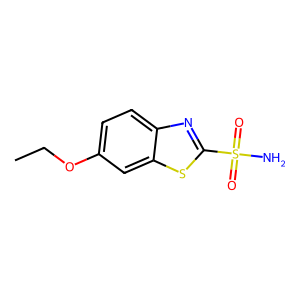

In [17]:
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
import matplotlib.pyplot as plt

smiles_sample = tox_data['smiles'][0].strip()
mol = Chem.MolFromSmiles(smiles_sample)
Draw.MolToImage(mol)


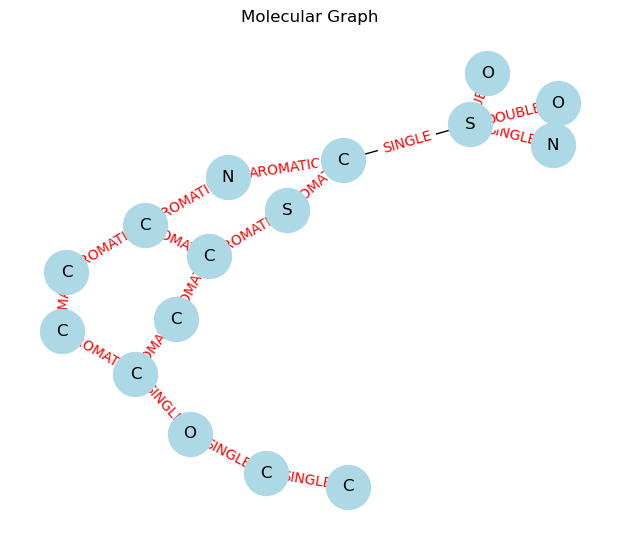

In [18]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    G = nx.Graph()
    
    # 添加原子节点
    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        G.add_node(idx, label=atom.GetSymbol())
    
    # 添加键（边）
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        bond_type = str(bond.GetBondType())
        G.add_edge(a1, a2, label=bond_type)
    
    return G, mol

def draw_graph(G):
    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')

    plt.figure(figsize=(6, 5))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=1000, font_size=12)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title("Molecular Graph")
    plt.axis('off')
    plt.show()
    
    
G, mol = smiles_to_graph(smiles_sample)
draw_graph(G)